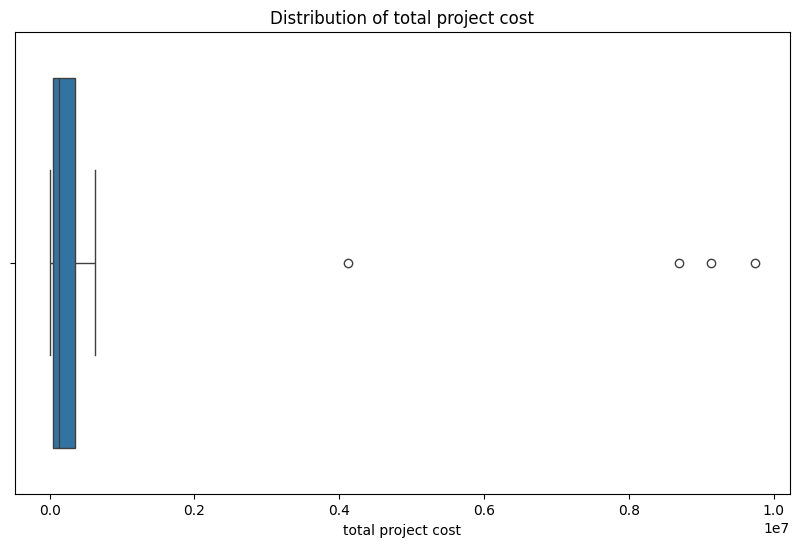

IQR Outliers: 4
Z-score Outliers: 3


C:\Users\Augah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 11.9858 - mean_absolute_error: 2.7801
Mean Squared Error on Testing Data: 11.98577880859375
Mean Absolute Error on Testing Data: 2.7801218032836914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


C:\Users\Augah\AppData\Local\Temp\ipykernel_13508\1223707056.py:117: RuntimeWarning: overflow encountered in expm1
  y_pred_exp = np.expm1(y_pred)


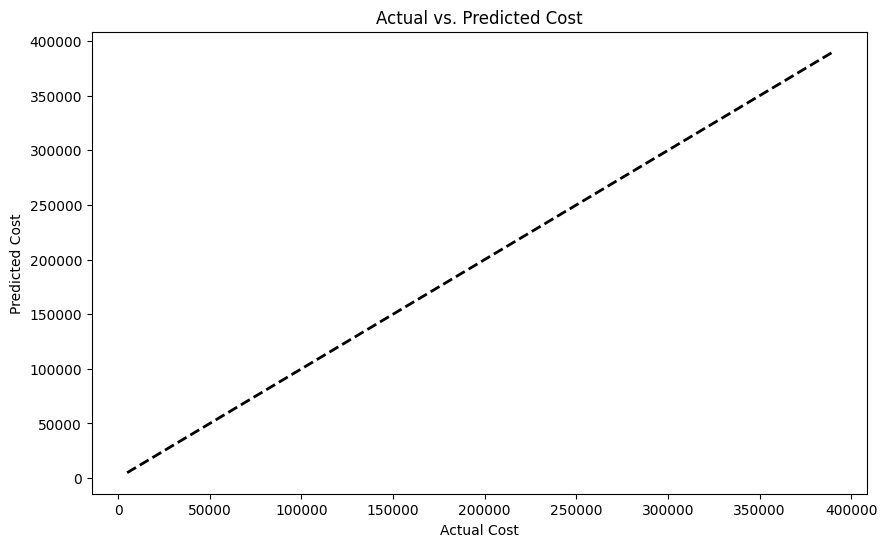

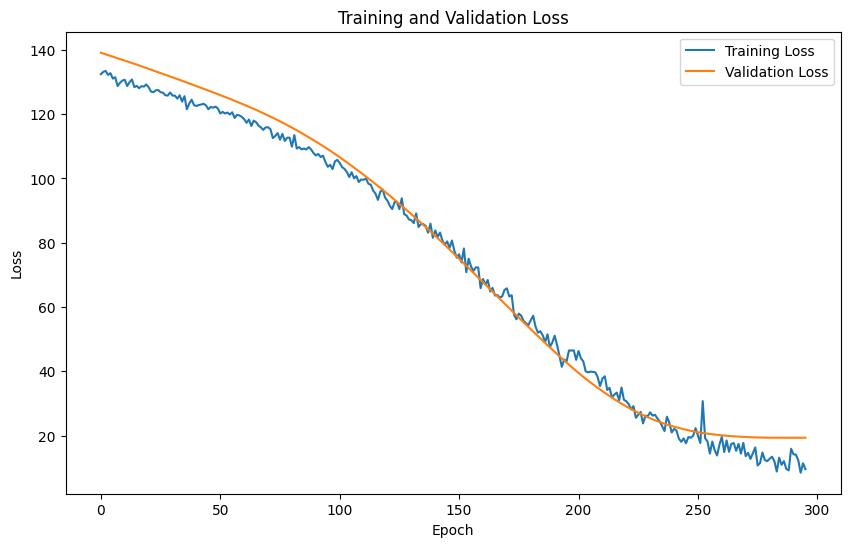

[2.0345182e+04 2.0104492e+03 2.7092705e+03 2.2055803e+03 5.2992593e+03
 1.6308926e+03 1.9619205e+05 2.1258528e+06 1.5895039e+04]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import zscore
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the dataset
file_path = "construction_cost_prediction.csv"
data = pd.read_csv(file_path)

# Correct the typo in column name
data.rename(columns={'number of units ': 'number of units'}, inplace=True)

# Fix inconsistencies in categorical variables
data['building function'] = data['building function'].str.lower()

# Plot distributions to detect outliers
def plot_distributions(df, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column])
    plt.title(f'Distribution of {column}')
    plt.show()

# Plot the distribution of the target variable
plot_distributions(data, 'total project cost')

# Function to identify outliers using IQR
def identify_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Function to identify outliers using Z-score
def identify_outliers_zscore(df, column, threshold=3):
    z_scores = zscore(df[column])
    return df[np.abs(z_scores) > threshold]

# Identify outliers using both methods
outliers_iqr = identify_outliers_iqr(data, 'total project cost')
outliers_zscore = identify_outliers_zscore(data, 'total project cost')

print(f"IQR Outliers: {outliers_iqr.shape[0]}")
print(f"Z-score Outliers: {outliers_zscore.shape[0]}")

# Removing outliers using IQR method
data_clean = data.drop(outliers_iqr.index)

# Separate features and target variable
X = data_clean.drop(columns=['total project cost'])
y = data_clean['total project cost']

# Log transform the target variable
y = np.log1p(y)

# Identify categorical and numerical columns
categorical_features = ['building function']
numerical_features = ['building height', 'builtup area', 'number of stories', 'number of columns', 'number of rooms', 'number of units']

# Preprocess the data: OneHotEncoding for categorical features and StandardScaling for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_preprocessed = preprocessor.fit_transform(X)

# Convert sparse matrix to dense matrix
X_preprocessed_dense = X_preprocessed.toarray()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_dense, y, test_size=0.2, random_state=42)

# Build a simpler ANN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=0)

# Evaluate the model on test data
mse, mae = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Data:", mse)
print("Mean Absolute Error on Testing Data:", mae)

# Predict on test data
y_pred = np.expm1(model.predict(X_test).flatten())

# Inverse log transform the predictions and the actual values
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.5)
plt.xlabel("Actual Cost")
plt.ylabel("Predicted Cost")
plt.title("Actual vs. Predicted Cost")
plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'k--', lw=2)
plt.show()

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
print(y_pred)

In [2]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [6]:
data['building function'].unique()

array(['residential', 'rural health clinic ', 'church steel structure',
       'warehouse', 'chain of shops', 'mall', 'shop mall',
       'steel warehouse', 'school admin block', 'hall', 'hostel',
       'abbatoir', 'blair toilet', 'township shop', 'industrial shop',
       'residential clusterhouse', 'cardiology  hospital building',
       'oncology hospital building ', 'university hostel',
       'rural health clinic'], dtype=object)